In [1]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
#     -O ./dataset/nlp_twitter.csv

In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [4]:
embedding_dim = 100
max_length = 16
trunc_type="post"
padding_type="post"
oov_tok = "<OOV>"

training_size=160000
test_portion=.1

split = int(test_portion * training_size)

In [5]:
corpus = []
num_sentences = 0

with open("./dataset/nlp_twitter.csv", encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=="0":
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [6]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [9]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O ./pretrained_model/glove.6B.100d.txt

In [10]:
embeddings_index = {};
with open("./pretrained_model/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype="float32");
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13871400  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,936,553
Trainable params: 65,153
Non-trainable params: 13,871,400
_______________________________________

In [12]:
num_epochs = 10

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/10
4500/4500 [==============================] - 47s 10ms/step - loss: 0.5675 - accuracy: 0.6996 - val_loss: 0.5311 - val_accuracy: 0.7288
Epoch 2/10
4500/4500 [==============================] - 25s 6ms/step - loss: 0.5267 - accuracy: 0.7331 - val_loss: 0.5141 - val_accuracy: 0.7450
Epoch 3/10
4500/4500 [==============================] - 42s 9ms/step - loss: 0.5109 - accuracy: 0.7446 - val_loss: 0.5163 - val_accuracy: 0.7432
Epoch 4/10
4500/4500 [==============================] - 57s 13ms/step - loss: 0.4986 - accuracy: 0.7522 - val_loss: 0.5000 - val_accuracy: 0.7498
Epoch 5/10
4500/4500 [==============================] - 47s 10ms/step - loss: 0.4906 - accuracy: 0.7583 - val_loss: 0.5016 - val_accuracy: 0.7521
Epoch 6/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.4841 - accuracy: 0.7627 - val_loss: 0.4999 - val_accuracy: 0.7534
Epoch 7/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.4772 - accuracy: 0.7662 - val_loss: 0.4970 - val

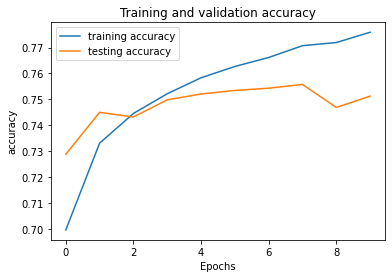

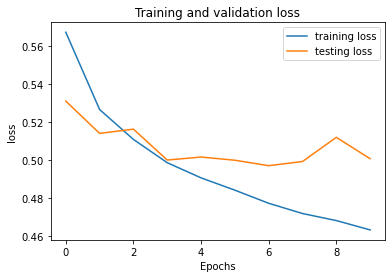

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric], label="training " + metric)
    plt.plot(history.history["val_"+metric], label="testing " + metric)
    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
model.save("./trained_model/nlp_transfer_learning_twitter")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./trained_model/nlp_transfer_learning_twitter\assets
